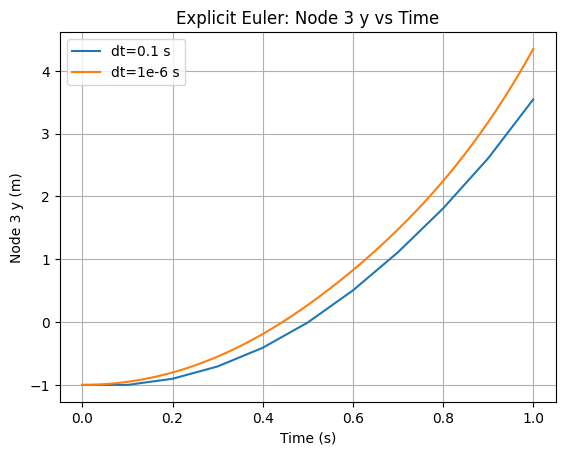

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def gradEs(xk, yk, xkp1, ykp1, l_k, k):
    F = np.zeros(4)
    L2 = (xkp1 - xk)**2 + (ykp1 - yk)**2
    L = np.sqrt(L2)
    if L == 0:
        return F
    c = (1 - L / l_k) * (L2 ** -0.5) / l_k
    F[0] = -c * (-2 * xkp1 + 2 * xk)
    F[1] = -c * (-2 * ykp1 + 2 * yk)
    F[2] = -c * ( 2 * xkp1 - 2 * xk)
    F[3] = -c * ( 2 * ykp1 - 2 * yk)
    return 0.5 * k * l_k * F

nodes = np.array([[0,0],[1,0],[2,0],[1,-1]], dtype=float)
springs = np.array([[0,1,10],[1,2,20],[0,3,5],[2,3,5]], dtype=float)

N = nodes.shape[0]
ndof = 2 * N
index_matrix = np.array([[2*int(i), 2*int(i)+1, 2*int(j), 2*int(j)+1] for i,j,_ in springs], dtype=int)
stiffness_matrix = springs[:,2]

x0 = np.zeros(ndof)
for i in range(N):
    x0[2*i], x0[2*i+1] = nodes[i]
m = np.ones(ndof)
g = 9.8

fixed_nodes = [0,2]
fixed_dofs = np.array(sorted([2*n for n in fixed_nodes] + [2*n+1 for n in fixed_nodes]), dtype=int)
free_DOF = np.array(sorted(set(range(ndof)) - set(fixed_dofs)), dtype=int)

def rest_lengths(x):
    L = np.zeros(len(stiffness_matrix))
    for s, ind in enumerate(index_matrix):
        xi, yi, xj, yj = x[ind]
        L[s] = np.hypot(xj - xi, yj - yi) if np.hypot(xj - xi, yj - yi) != 0 else 1e-12
    return L

l_k = rest_lengths(x0)

def getFexternal(m):
    W = np.zeros_like(m)
    for i in range(N):
        W[2*i+1] = -m[2*i+1]*g
    return W

def myInt(t_new, x_old, u_old, free_DOF, stiffness_matrix, index_matrix, m, dt, l_k):
    ndof = x_old.shape[0]
    f_spring = np.zeros(ndof)
    for i in range(stiffness_matrix.shape[0]):
        ind = index_matrix[i]
        xi, yi, xj, yj = x_old[ind[0]], x_old[ind[1]], x_old[ind[2]], x_old[ind[3]]
        df = gradEs(xi, yi, xj, yj, l_k[i], stiffness_matrix[i])
        f_spring[ind] += df
    f_ext = getFexternal(m)
    f_total = f_spring - f_ext
    a_old = f_total / m
    x_new = x_old.copy()
    u_new = u_old.copy()
    u_new[free_DOF] = u_old[free_DOF] + dt * a_old[free_DOF]
    x_new[free_DOF] = x_old[free_DOF] + dt * u_old[free_DOF]
    return x_new, u_new

def run_explicit(dt, T=1.0):
    x = x0.copy()
    u = np.zeros(ndof)
    t = 0.0
    times = [0.0]
    y3 = [x[2*3+1]]
    nsteps = int(np.ceil(T/dt))
    for _ in range(nsteps):
        t_new = min(T, t + dt)
        h = t_new - t
        x, u = myInt(t_new, x, u, free_DOF, stiffness_matrix, index_matrix, m, h, l_k)
        t = t_new
        times.append(t)
        y3.append(x[2*3+1])
        if not np.isfinite(x).all() or np.max(np.abs(x)) > 1e6:
            break
    return np.array(times), np.array(y3)

t1, y3_01  = run_explicit(0.1, 1.0)
t2, y3_1e6 = run_explicit(1e-6, 1.0)

plt.figure()
plt.plot(t1, y3_01,  label='dt=0.1 s')
plt.plot(t2, y3_1e6, label='dt=1e-6 s')
plt.xlabel('Time (s)')
plt.ylabel('Node 3 y (m)')
plt.title('Explicit Euler: Node 3 y vs Time')
plt.grid(True)
plt.legend()
plt.show()
